In [3]:
from pathlib import Path
from smokingml.datasets.nursing_dataset_v1 import nursing_dataset_v1, nursingv1_train_dev_test_split, utils
from smokingml.modules import evaluate_loop
from torch.utils.data import DataLoader
from torch import nn
import torch
import matplotlib.pyplot as plt
from smokingml.utils import plot_and_save_cm
from tqdm import tqdm

In [16]:
def evaluate_loop(model: nn.Module, criterion: nn.Module, loader: DataLoader, device: str) -> tuple[torch.tensor, torch.tensor]:
    y_preds = []
    y_true = []
    loss_total = 0

    model.eval()
    for X,y in loader:
        y_true.append(y)
        X,y = X.to(device), y.to(device)
        logits = model(X)
        loss_total += criterion(logits, y).item()
        pred = torch.round(nn.Sigmoid()(logits)).detach().to('cpu')
        y_preds.append(pred)


    return (torch.cat(y_true), torch.cat(y_preds), loss_total / len(loader))

In [5]:
nursingv1_dir = Path('../data/nursingv1_dataset')
session_ids = utils.get_all_session_ids(nursingv1_dir)[:10]
train_dataset, dev_dataset, _ = nursingv1_train_dev_test_split(
    nursingv1_dir,
    train_size=1-0.5,
    dev_size=0.5,
    test_size=0.0,
    shuffle=True,
    session_ids=session_ids,
    for_cnn=True
)
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
devloader = DataLoader(dev_dataset, batch_size=64, shuffle=True)

In [6]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(in_features=303, out_features=10)
        self.relu = nn.ReLU()
        self.out = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        x = self.h1(x)
        x = self.relu(x)
        logits = self.out(x)
        return logits

device = 'cuda:1'
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

In [7]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv1d(in_channels=3, out_channels=2, kernel_size=5, padding='same', bias=False)
        self.ln1 = nn.LayerNorm((2,101))
        self.relu = nn.ReLU()

        self.h1 = nn.Linear(in_features=202, out_features=10)
        self.h2 = nn.Linear(in_features=10, out_features=1)
        

    def forward(self, x):
        x = self.c1(x)
        x = self.ln1(x)
        x = self.relu(x)

        x = x.flatten(start_dim=1)
        x = self.h1(x)
        x = self.relu(x)
        logits = self.h2(x)

        return logits

device = 'cuda:1'
model = CNNModel().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

In [29]:
class FCN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # First Convolution Block
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=128, kernel_size=8)
        self.bn1 = nn.BatchNorm1d(num_features=128)
        self.relu1 = nn.ReLU()

        # Second Convolution Block
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(num_features=256)
        self.relu2 = nn.ReLU()

        # Third Convolution Block
        self.conv3 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(num_features=128)
        self.relu3 = nn.ReLU()

        # Global Average Pooling
        self.gp = lambda x: torch.mean(x, dim=2)    # Take mean across each feature map (N, C, L) => (N,C)
        
        # Output Later
        self.output = nn.Linear(in_features=128, out_features=1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.gp(x)
        logits = self.output(x)

        return logits

model = FCN().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8)

100%|██████████| 2850/2850 [00:05<00:00, 476.87it/s]


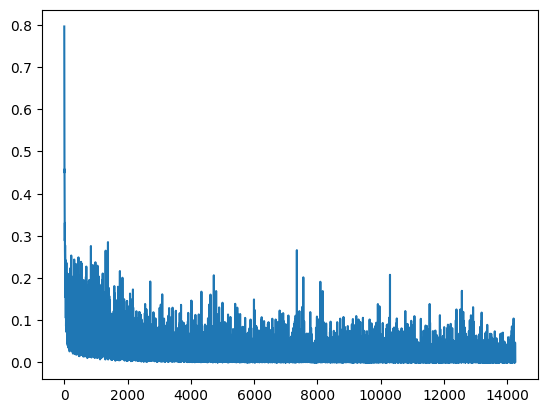

In [30]:

model.train()
lossi = []
for i in range(5):
    for (X_tr,y_tr) in tqdm(trainloader):
        X_tr,y_tr = X_tr.to(device),y_tr.to(device)
        logits = model(X_tr)
        loss = criterion(logits,y_tr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())


plt.plot(lossi)

In [31]:
y_true, y_pred, loss = evaluate_loop(model, criterion, trainloader, device)

# with torch.no_grad():
#     y_true = torch.Tensor()
#     y_pred = torch.Tensor()
#     y_logits = torch.Tensor()
#     loss_total = 0
#     for (Xi,yi) in tqdm(trainloader):
#         y_true = torch.cat([y_true,yi])

#         Xi,yi = Xi.to(device),yi.to(device)
#         logits = model(Xi)
#         loss = criterion(logits,yi)
#         loss_total += loss.item()
        
#         y_logits = torch.cat([y_logits,torch.sigmoid(logits).detach().cpu()])
#         y_pred = torch.cat([y_pred,torch.sigmoid(logits).round().detach().cpu()])


plot_and_save_cm(y_true, y_pred, 'cm.jpg')
loss

0.010244890466102222

In [32]:
y_true, y_pred, loss = evaluate_loop(model, criterion, devloader, device)
plot_and_save_cm(y_true, y_pred, 'cm.jpg')
loss

0.3090636387665905

In [19]:
dev_dataset.session_ids

array([60, 27, 41, 53,  8])

In [22]:
session = dev_dataset.load_one_windowed_session(60)

one_guyloader = DataLoader(session, batch_size=64)

with torch.no_grad():
    y_true = torch.Tensor()
    y_pred = torch.Tensor()
    y_logits = torch.Tensor()
    loss_total = 0
    for (Xi,yi) in tqdm(one_guyloader):
        y_true = torch.cat([y_true,yi])

        Xi,yi = Xi.reshape(-1,3,101).to(device),yi.to(device)
        logits = model(Xi)
        loss = criterion(logits,yi)
        loss_total += loss.item()
        
        y_logits = torch.cat([y_logits,torch.sigmoid(logits).detach().cpu()])
        y_pred = torch.cat([y_pred,torch.sigmoid(logits).round().detach().cpu()])


plot_and_save_cm(y_true, y_pred, 'cm.jpg')

100%|██████████| 510/510 [00:00<00:00, 1365.68it/s]


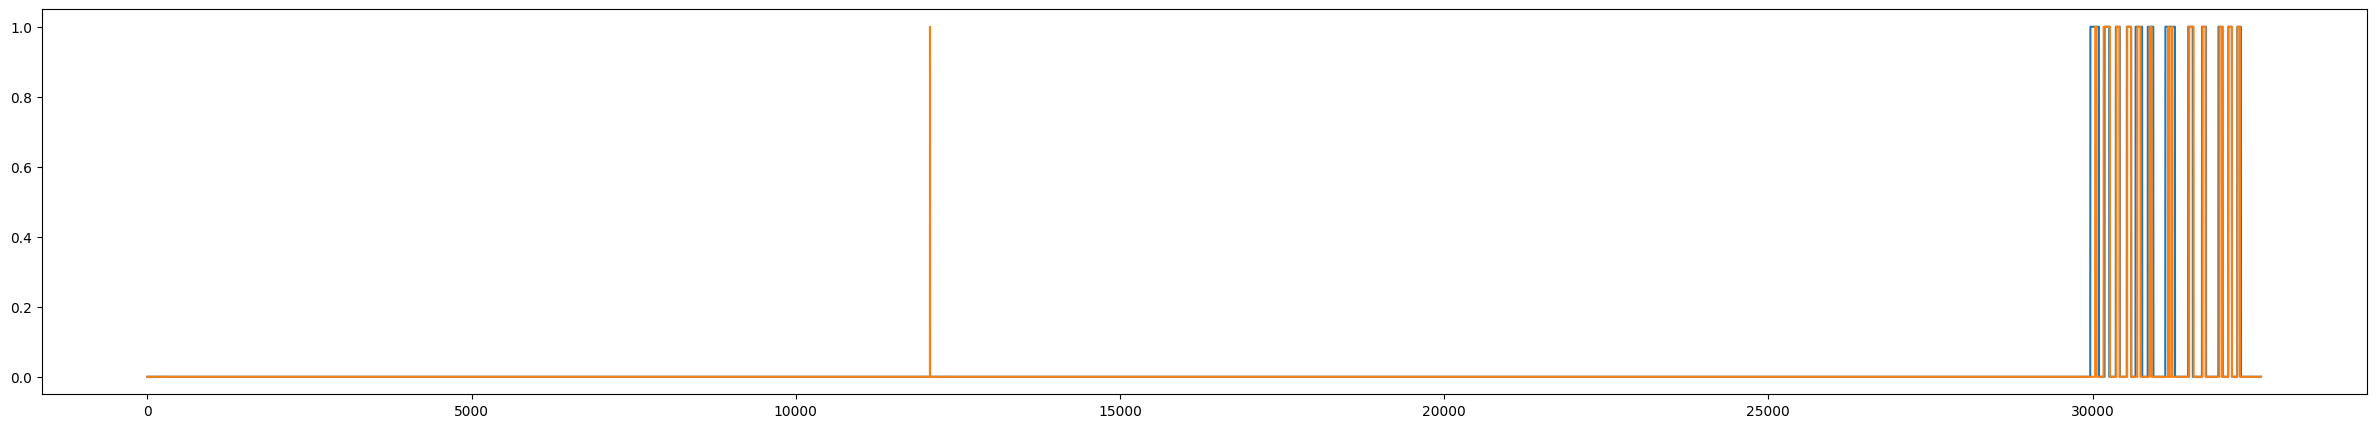

In [23]:
plt.figure(figsize=(30,5))
plt.plot(y_true)
plt.plot(y_pred)
plt.savefig('out.pdf')